**1. 드라이브 마운트**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. 데이터 불러오기**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
parasite = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/NLP/gisaengchung.xlsx')
parasite['label'] = 1 # 기생충은 0
dwar = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/NLP/dwar.xlsx')
dwar['label'] = 0 # 디워는 1

**3. 데이터 전처리**

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('all')
nltk.download('popular')

3-1) 중복 행 제거

In [ ]:
print('기생충 데이터 수 :',len(parasite))
print('기생충 중복 제외 데이터 :', parasite['contents'].nunique())
print('기생충 라벨 데이터 수 :', parasite['label'].nunique())
print()
print('디워 데이터 수 :',len(dwar))
print('디워 중복 제외 데이터 :', dwar['contents'].nunique())
print('디워 라벨 데이터 수 :', dwar['label'].nunique())
print()
parasite.drop_duplicates(subset=['contents'], inplace=True)
print('중복 삭제 후, 기생충 데이터 수 :',len(parasite))
print('중복 삭제 후, 기생충 중복 제외 데이터 :',parasite['contents'].nunique())

3-2) 표제어 추출

In [7]:
def preprocessing(text):
    # 단어 토큰화
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)] 
   
    # 불용어 제거
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop]
    
    # 3 단어 이내 단어 제거
    tokens = [word for word in tokens if len(word) >= 3]
       
    # 소문자화
    tokens = [word.lower() for word in tokens]
    
    # 표제어 추출
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(word) for word in tokens]

    preprocessed_text= ' '.join(tokens)
    return preprocessed_text

In [8]:
parasite['contents_pre'] = parasite['contents'].apply(lambda x: preprocessing(x))
dwar['contents_pre'] = dwar['contents'].apply(lambda x: preprocessing(x))

In [ ]:
parasite.head()
dwar.head()

**4. Train & Test 분류**

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

In [11]:
parasite_train = parasite[:int(len(parasite)*0.75)]
dwar_train = dwar[:int(len(dwar)*0.75)]
parasite_test = parasite[int(len(parasite)*0.75):]
dwar_test = dwar[int(len(dwar)*0.75):]

train_data = pd.concat([parasite_train, dwar_train])
test_data = pd.concat([parasite_test, dwar_test])

In [12]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
X_train = []
for sentence in tqdm(train_data['contents_pre']):
    X_train.append(sentence)

100%|██████████| 481/481 [00:00<00:00, 677227.33it/s]


In [14]:
print(X_train[:3])

["remarkably stingy 10/10 rating 'll first person acknowledge roughly 2600 title 've rated parasite one n't masterpiece n't know is.i going keep vague plot-front n't know anything going really excited see progress unfold satisfying unexpected ways.what say film 've seen put many different emotional state 132-minute runtime without ever feeling muddled tonally inconsistent part movie hilarious part heartbreaking other part insanely suspenseful honestly sure 've felt close edge seat since final season breaking bad way back 2013 .and perfectly paced beautifully directed amazingly acted every single member cast all character understandable sympathetic degree amount conflict drama tension derived narrative clear hero villain staggering you come care them.i stumped come flaw movie and sure 've seen many movie hard fault rare movie appeal gut level excites degree also close technically perfect extremely entertaining thoroughly moving many different way icing cake ton social commentary heavy t

In [15]:
X_test = []
for sentence in tqdm(test_data['contents_pre']):
    X_test.append(sentence)

100%|██████████| 162/162 [00:00<00:00, 504437.45it/s]


In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'movie': 1, 'film': 2, 'the': 3, "n't": 4, 'helpful': 5, 'one': 6, 'review': 7, 'like': 8, 'family': 9, 'found': 10, 'story': 11, 'good': 12, 'korean': 13, 'vote': 14, 'wa': 15, 'sign': 16, 'parasite': 17, 'permalink': 18, 'this': 19, 'see': 20, 'time': 21, 'dragon': 22, 'bad': 23, 'war': 24, 'best': 25, 'get': 26, 'would': 27, 'make': 28, 'even': 29, 'really': 30, 'character': 31, 'well': 32, 'acting': 33, 'people': 34, 'watch': 35, 'way': 36, 'much': 37, 'director': 38, 'made': 39, 'plot': 40, 'scene': 41, 'many': 42, 'but': 43, 'year': 44, 'could': 45, 'bong': 46, 'great': 47, 'poor': 48, 'park': 49, 'effect': 50, 'think': 51, 'thing': 52, 'class': 53, 'joon': 54, 'first': 55, 'say': 56, 'every': 57, 'ho': 58, 'seen': 59, 'rich': 60, 'korea': 61, 'lot': 62, 'better': 63, 'd': 64, 'know': 65, "'ve": 66, 'and': 67, 'also': 68, 'there': 69, 'come': 70, 'actor': 71, 'end': 72, 'ki': 73, 'take': 74, 'give': 75, 'something': 76, 'special': 77, 'i': 78, 'feel': 79, 'life': 80, 'want': 81,

In [17]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [18]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7216
등장 빈도가 2번 이하인 희귀 단어의 수: 4689
단어 집합에서 희귀 단어의 비율: 64.98059866962306
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.091172214182345


In [19]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2528


In [20]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [21]:
print(X_train[:3])

[[1943, 132, 132, 176, 114, 55, 569, 455, 66, 781, 17, 6, 4, 101, 4, 65, 918, 78, 87, 232, 1611, 40, 1253, 4, 65, 143, 87, 30, 1411, 20, 1944, 1412, 406, 191, 56, 2, 66, 59, 207, 42, 148, 689, 611, 1945, 115, 1946, 137, 94, 407, 1254, 116, 1, 727, 116, 1947, 1413, 116, 1612, 1255, 570, 144, 66, 233, 494, 362, 473, 263, 495, 1256, 1114, 23, 36, 129, 1115, 67, 363, 1116, 571, 256, 1613, 549, 57, 496, 348, 192, 234, 31, 1948, 1949, 1117, 1950, 1414, 145, 572, 1951, 573, 574, 550, 575, 88, 70, 330, 1952, 78, 70, 1001, 1, 67, 144, 66, 59, 42, 1, 180, 1614, 728, 1, 1257, 1615, 208, 1117, 68, 494, 1118, 209, 551, 177, 837, 1002, 42, 148, 36, 1953, 1119, 123, 383, 1258, 289, 1, 6, 87, 364, 518, 193, 1259, 6, 434, 456, 54, 58, 46, 39, 42, 47, 2, 140, 23, 6, 29, 690, 691, 518, 1616, 331, 235, 70, 21, 1415, 25, 2, 6, 612], [4, 576, 130, 21, 135, 1, 42, 158, 919, 3, 1, 112, 173, 8, 2, 93, 1003, 151, 145, 1260, 838, 29, 273, 2, 30, 113, 12, 1004, 78, 89, 2, 782, 121, 69, 42, 474, 1, 552, 202, 2, 78

In [22]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [23]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [24]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

481
481


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 562
리뷰의 평균 길이 : 95.79417879417879


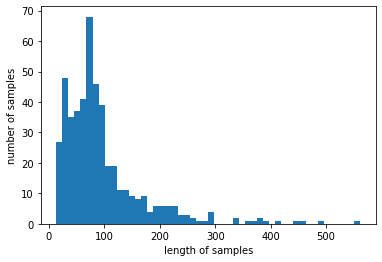

In [25]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 리뷰의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [27]:
max_len = 300
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 300 이하인 리뷰의 비율: 97.5051975051975


In [28]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

**5. 실제 학습 단계**

In [29]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
embedding_dim = 100
hidden_units = 128

In [31]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [33]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
6/6 [==============================] - ETA: 0s - loss: 0.7305 - acc: 0.7057
Epoch 1: val_acc improved from -inf to 0.00000, saving model to best_model.h5
6/6 [==============================] - 7s 817ms/step - loss: 0.7305 - acc: 0.7057 - val_loss: 0.9140 - val_acc: 0.0000e+00
Epoch 2/15
6/6 [==============================] - ETA: 0s - loss: 0.5406 - acc: 0.7656
Epoch 2: val_acc improved from 0.00000 to 0.25773, saving model to best_model.h5
6/6 [==============================] - 4s 689ms/step - loss: 0.5406 - acc: 0.7656 - val_loss: 1.0215 - val_acc: 0.2577
Epoch 3/15
6/6 [==============================] - ETA: 0s - loss: 0.4386 - acc: 0.8620
Epoch 3: val_acc improved from 0.25773 to 0.41237, saving model to best_model.h5
6/6 [==============================] - 4s 679ms/step - loss: 0.4386 - acc: 0.8620 - val_loss: 0.9872 - val_acc: 0.4124
Epoch 4/15
6/6 [==============================] - ETA: 0s - loss: 0.2233 - acc: 0.9479
Epoch 4: val_acc improved from 0.41237 to 0.63918, 

In [34]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

6/6 [==============================] - 1s 118ms/step - loss: 0.2249 - acc: 0.9074

 테스트 정확도: 0.9074


In [35]:
def classify_predict(new_sentence):
  new_sentence = preprocessing(new_sentence) # 토큰화
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 기생충 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 디워 리뷰입니다.\n".format((1 - score) * 100))

In [41]:
classify_predict("So was it a dragon? or a snake?")

1/1 [==============================] - 0s 111ms/step
87.11% 확률로 기생충 리뷰입니다.

